<a href="https://colab.research.google.com/github/tuanymariiah/projeto_rossmam/blob/main/Projeto_Rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das Bibliotecas


In [1]:
!pip install inflection
!pip install Boruta

     |████████████████████████████████| 56 kB 2.6 MB/s 


In [73]:
import pandas as pd
import numpy as np
import math
import inflection # biblioteca para renomear o nome das colunas
import seaborn as sns
import datetime
import xgboost as xgb
import pickle


from matplotlib              import pyplot as plt
from scipy                   import stats  as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.display         import Image
from sklearn.ensemble        import RandomForestRegressor
from boruta                  import BorutaPy
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV


#Funções

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed( range( 1, kfold+1 ) ):
    
    if verbose:
      print( '\nKFold Number: {}'.format( k ) )
    # start and end date for validation 
    validation_start_date = x_training['Date'].max() - datetime.timedelta( days=k*6*7)
    validation_end_date = x_training['Date'].max() - datetime.timedelta( days=(k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['Date'] < validation_start_date]
    validation = x_training[(x_training['Date'] >= validation_start_date) & (x_training['Date'] <= validation_end_date)]

    # training and validation dataset
    # training
    xtraining = training.drop( ['Date', 'Sales'], axis=1 ) 
    ytraining = training['Sales']

    # validation
    xvalidation = validation.drop( ['Date', 'Sales'], axis=1 )
    yvalidation = validation['Sales']

    # model
    m = model.fit( xtraining, ytraining )

    # prediction
    yhat = m.predict( xvalidation )

    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

    # store performance of each kfold iteration
    mae_list.append(  m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

  return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

#Carrega Dataset

In [4]:
base_train = '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/dataset/train.csv'
base_store = '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/dataset/store.csv'
df_sales_raw = pd.read_csv(base_train, low_memory=False)
df_store_raw = pd.read_csv(base_store, low_memory=False)
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# Descrição dos Dados

In [5]:
df1 = df_raw.copy()

##Dimensão dos Dados

In [6]:
print(f'Quantidade de Linhas {df1.shape[0]} e Quantidade de Colunas {df1.shape[1]}')

Quantidade de Linhas 308219 e Quantidade de Colunas 18


## Apresentação do Tipo dos Dados

In [7]:
df1.dtypes

Store                          int64
DayOfWeek                    float64
Date                          object
Sales                        float64
Customers                    float64
Open                         float64
Promo                        float64
StateHoliday                  object
SchoolHoliday                float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [8]:
df1['Date'] = pd.to_datetime(df1['Date'])

##Quantidade de dados nulos

In [9]:
df1.isna().sum()

Store                             0
DayOfWeek                         1
Date                              1
Sales                             1
Customers                         1
Open                              1
Promo                             1
StateHoliday                      1
SchoolHoliday                     1
StoreType                         0
Assortment                        0
CompetitionDistance             790
CompetitionOpenSinceMonth     98017
CompetitionOpenSinceYear      98017
Promo2                            0
Promo2SinceWeek              155290
Promo2SinceYear              155290
PromoInterval                155290
dtype: int64

Tratamento dos dados faltantes

In [10]:
#CompetitionDistance
df1['CompetitionDistance'].fillna(200000.0, inplace = True)  #assumindo que uma distancia maior que a max, o competidor nao participou           
#CompetitionOpenSinceMonth
df1['CompetitionOpenSinceMonth'] = df1.apply( lambda x: x['Date'].month if math.isnan( x['CompetitionOpenSinceMonth'] ) else x['CompetitionOpenSinceMonth'], axis=1 )                             
#CompetitionOpenSinceYear
df1['CompetitionOpenSinceYear'] = df1.apply( lambda x: x['Date'].year if math.isnan( x['CompetitionOpenSinceYear'] ) else x['CompetitionOpenSinceYear'], axis=1 )                             
#Promo2SinceWeek 
df1['Promo2SinceWeek'] = df1.apply( lambda x: x['Date'].week if math.isnan( x['Promo2SinceWeek'] ) else x['Promo2SinceWeek'], axis=1 )                             
#Promo2SinceYear  
df1['Promo2SinceYear'] = df1.apply( lambda x: x['Date'].year if math.isnan( x['Promo2SinceYear'] ) else x['Promo2SinceYear'], axis=1 )                             
#PromoInterval   
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['PromoInterval'].fillna(0, inplace=True )
df1['month_map'] = df1['Date'].dt.month.map( month_map )
df1['is_promo'] = df1[['PromoInterval', 'month_map']].apply( lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['month_map'] in x['PromoInterval'].split( ',' ) else 0, axis=1 )

df1.dropna(inplace=True)

mudando o tipo de algumas colunas

In [11]:
df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(int)
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(int)

df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(int)
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(int)


##Análise Estatísstica Descritiva*

- kurtosis
- skew

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.357198,558.0,321.831213,-0.000706,-1.200156
1,DayOfWeek,1.0,7.0,6.0,4.003618,4.0,1.994167,-0.004986,-1.241098
2,Sales,0.0,41551.0,41551.0,5993.145994,6000.0,3961.418488,0.568196,1.519275
3,Customers,0.0,5458.0,5458.0,637.858577,617.0,466.406418,1.599578,7.138470
4,Open,0.0,1.0,1.0,0.828446,1.0,0.376992,-1.742464,1.036187
5,Promo,0.0,1.0,1.0,0.398500,0.0,0.489589,0.414633,-1.828091
6,SchoolHoliday,0.0,1.0,1.0,0.158339,0.0,0.365059,1.871821,1.503725
7,CompetitionDistance,20.0,200000.0,199980.0,5938.732715,2330.0,12509.181481,10.215441,147.689075
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.738497,7.0,3.391312,0.017984,-1.276454
9,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.627728,2012.0,5.648443,-6.409746,105.685042


In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

StateHoliday      4
StoreType         4
Assortment        3
PromoInterval     4
month_map        10
dtype: int64

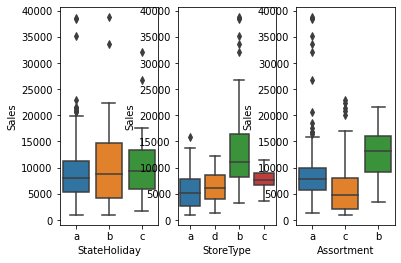

In [14]:
aux = df1[(df1['StateHoliday'] != '0') & (df1['Sales'] > 0)]
plt.subplot( 1, 3, 1 );
sns.boxplot( x='StateHoliday', y='Sales', data=aux );
plt.subplot( 1, 3, 2 );
sns.boxplot( x='StoreType', y='Sales', data=aux );
plt.subplot( 1, 3, 3 );
sns.boxplot( x='Assortment', y='Sales', data=aux );

#Mapa Mental de Hipóteses

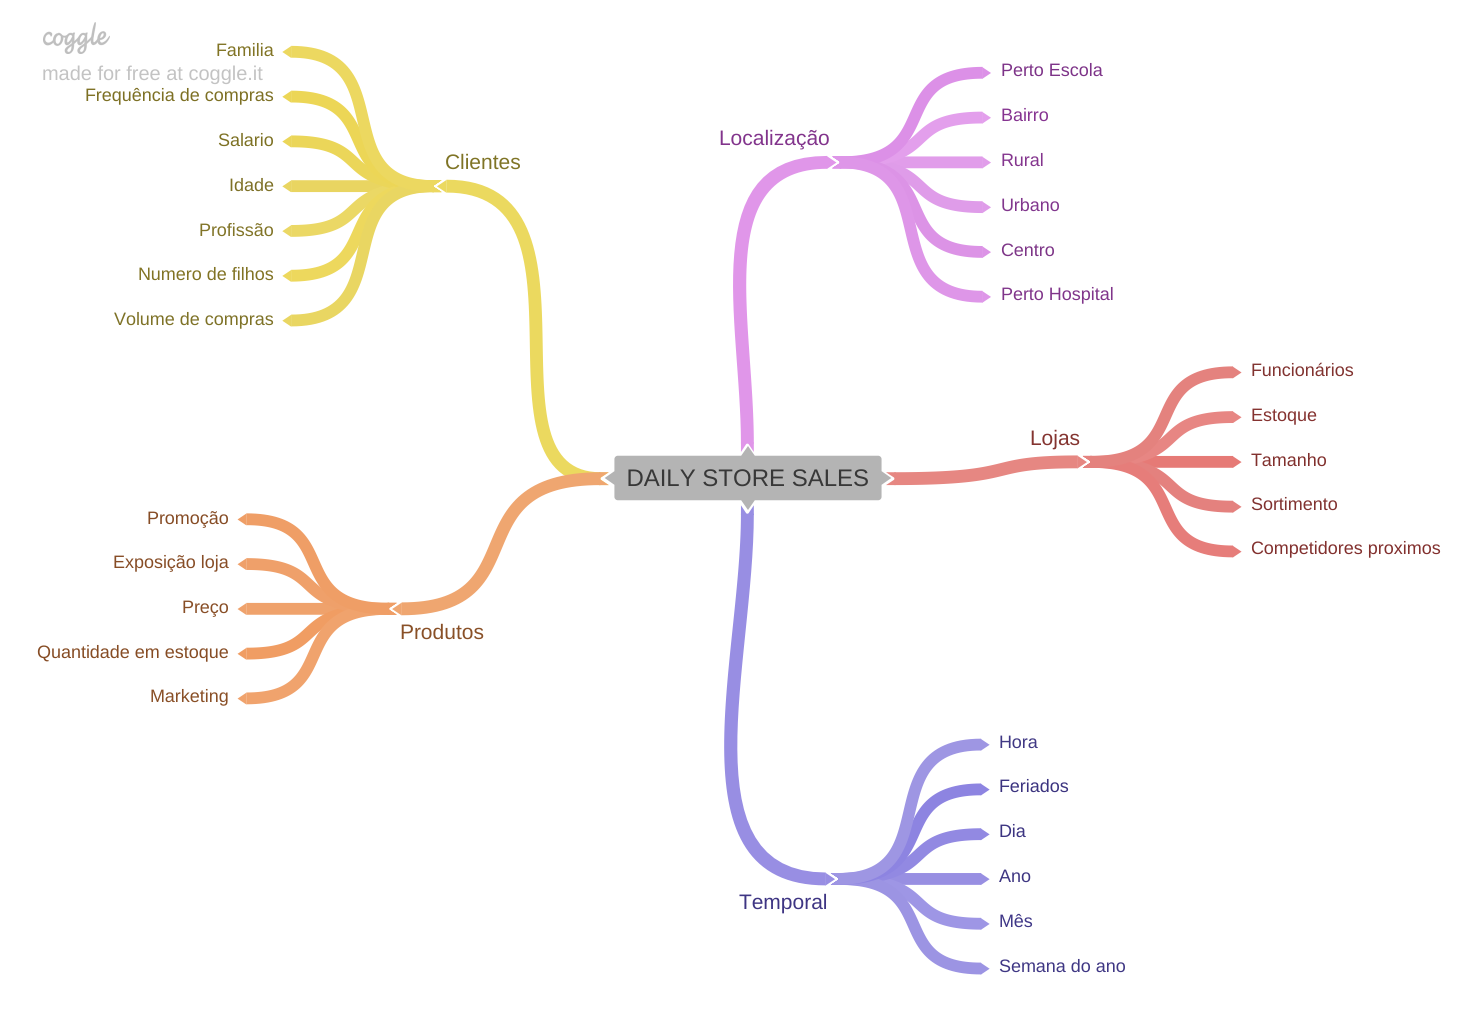

In [15]:
Image('/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/imagens/mindmap.png')


##Criação de Hipóteses
- Hipótese de Loja
  1. Lojas com maior quadro de funcionarios deveriam vender mais

  2. Lojas com maior estoque deveriam vender mais

  3. Lojas de maior porte deveriam vender mais

  4. Lojas com maior sortimento deveriam vender mais

  5. Lojas com competidores mais proximos deveriam vender menos

  6. Lojas com competidores a mais tempo deveriam vender mais

* Hipótese Produto
  1. Lojas que investem mais em marketing deveriam vender mais

  2. Lojas que expões mais o produto na vitrine deveriam vender mais

  3. Lojas que tem preços menores nos produtos deveriam vender mais

  4. Lojas com promoções mais agressivas deveriam vender mais

  5. Lojas com promoções ativas por mais tempo deveriam vender mais

  6. Lojas com mais dias de promoção deveriam vender mais

  7. Lojas com mais promoções consecutivas deveriam vender mais

* Hipótese Tempo
  1. Lojas abertas durante o feriado de Natal deveriam vender mais

  2. Lojas deveriam vender mais ao longo dos anos

  3. Lojas deveriam vender mais no segundo semestre do ano

  4. Lojas vender mais depois do dia 10 de cada mês

  5. Lojas deveriam vender menos em finais de semana

  6. Lojas deveriam vender menos durante os feriados escolares

- Lista Final de Hipóteses
  1. Lojas com maior sortimento deveriam vender mais

  2. Lojas com competidores mais proximos deveriam vender menos

  3. Lojas com competidores a mais tempo deveriam vender mais

  4. Lojas com promoções ativas por mais tempo deveriam vender mais

  5. Lojas com mais dias de promoção deveriam vender mais

  6. Lojas com mais promoções consecutivas deveriam vender mais

  7. Lojas abertas durante o feriado de Natal deveriam vender mais

  8. Lojas deveriam vender mais ao longo dos anos

  9. Lojas deveriam vender mais no segundo semestre do ano

  10. Lojas vender mais depois do dia 10 de cada mês

  11. Lojas deveriam vender menos em finais de semana

  12. Lojas deveriam vender menos durante os feriados escolares

#Feature Engenering

In [16]:
df2 = df1.copy()

In [17]:
# year
df2['year'] = df2['Date'].dt.year

# month
df2['month'] = df2['Date'].dt.month

# day
df2['day'] = df2['Date'].dt.day

# week of year
df2['week_of_year'] = df2['Date'].dt.isocalendar().week

# year_week
df2['year_week'] = df2['Date'].dt.strftime('%Y-%W')

# competition since
df2['CompetitionSince'] = df2.apply(lambda x: datetime.datetime(year=x['CompetitionOpenSinceYear'], month=x['CompetitionOpenSinceMonth'], day=1), axis=1)
df2['CompetitionTimeMonth'] =  ((df2['Date'] - df2['CompetitionSince'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['PromoSince'] = df2['Promo2SinceYear'].astype(str) + '-' + df2['Promo2SinceWeek'].astype(str)
df2['PromoSince'] = df2['PromoSince'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['PromoTimeEeek'] = ((df2['Date'] - df2['PromoSince'])/7).apply(lambda x: x.days).astype(int)

# assortment 
df2['Assortment'] = df2['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['StateHoliday'] = df2['StateHoliday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

# Filtragem de Linhas


In [18]:
df3 = df2.copy()

In [19]:
#filtra pelas vendas cujo as lojas estavam abertas
df3 = df3.loc[(df3['Open'] != 0)  & (df3['Sales'] > 0)]

## Seleção de Colunas

In [20]:
#'customers' - não está disponivel na hora da predição
cols_drop = ['Customers', 'Open', 'PromoInterval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

#Análise Explorativa dos Dados
---
Esta etapa serve para medir o impacto das outras variáveis em relação a variável resposta que normalmente é conhecida como: classe, label ou target

In [21]:
df4= df3.copy()

##Análise Univariada
---

### Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


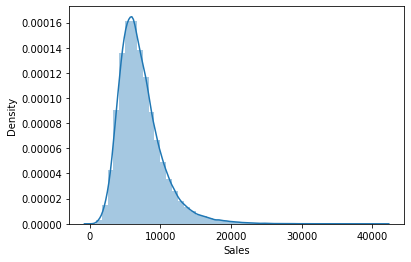

In [22]:
sns.distplot( df4['Sales'], kde=True  );


###Variáveis Numéricas

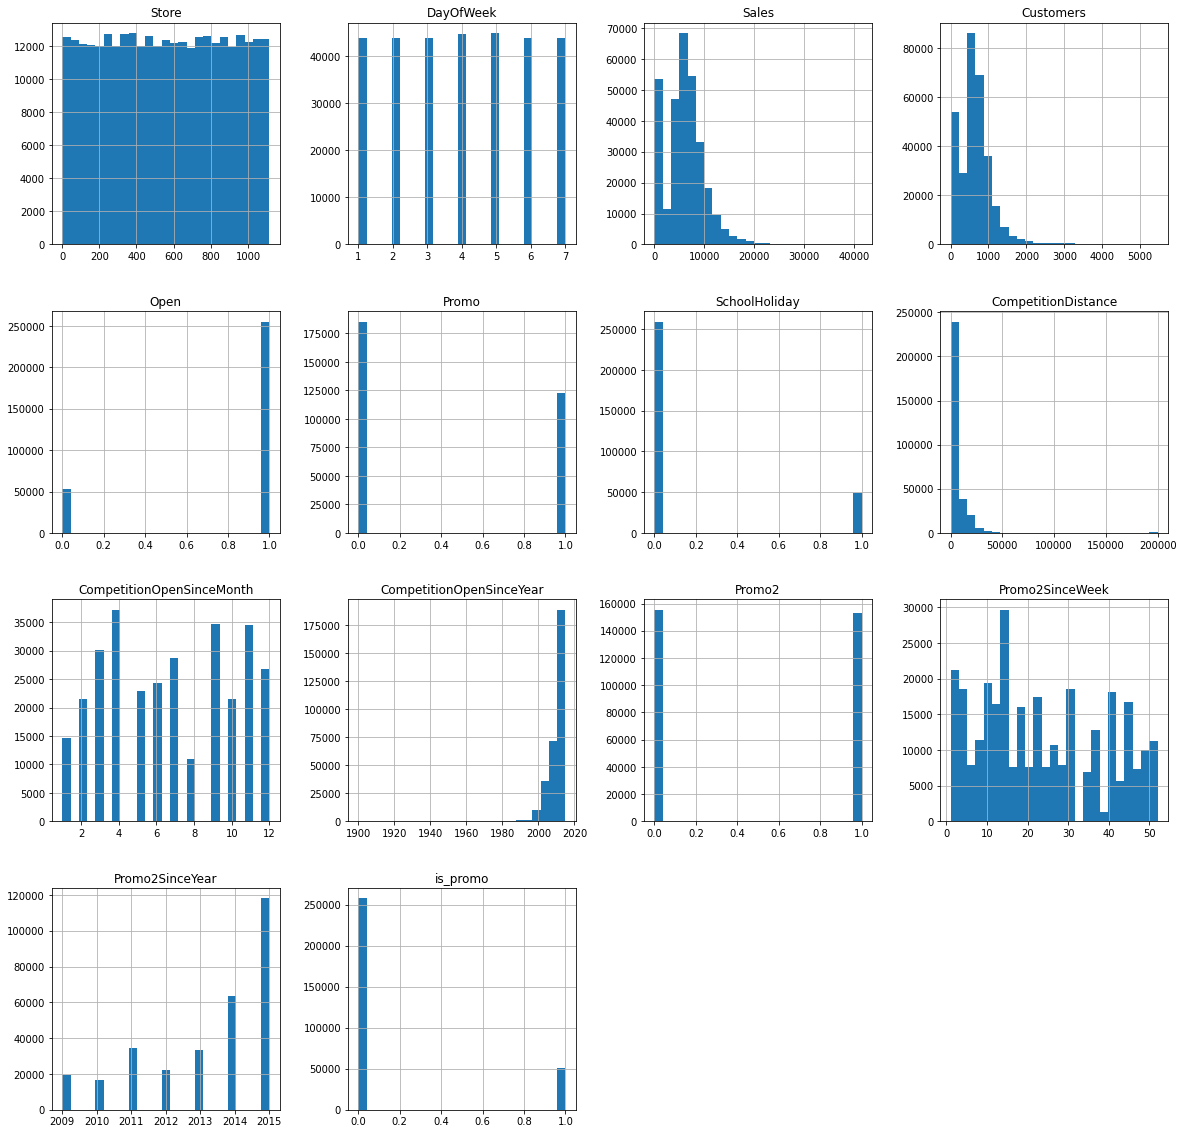

In [23]:
num_attributes.hist(bins=25,figsize=(20,20));

###Variável Categórica

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


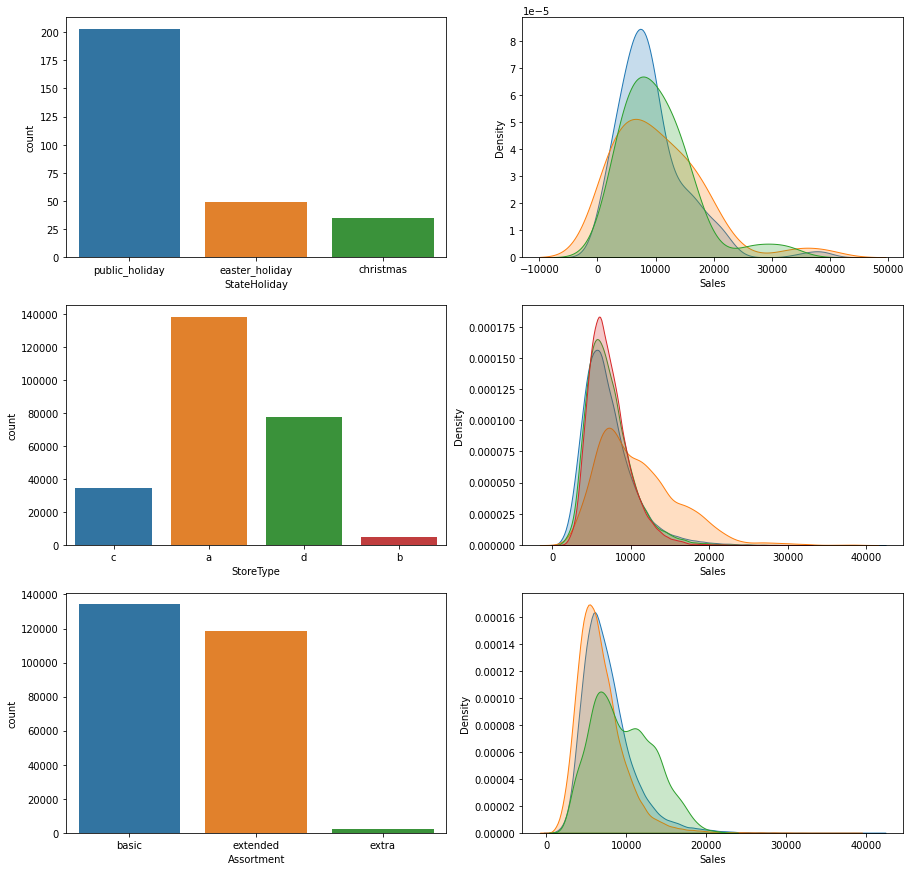

In [24]:
# state_holiday
plt.figure(figsize=(15,15))

plt.subplot( 3, 2, 1 );
a = df4[df4['StateHoliday'] != 'regular_day']
sns.countplot( a['StateHoliday'] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['StateHoliday'] == 'public_holiday']['Sales'], label='public_holiday', shade=True );
sns.kdeplot( df4[df4['StateHoliday'] == 'easter_holiday']['Sales'], label='easter_holiday', shade=True );
sns.kdeplot( df4[df4['StateHoliday'] == 'christmas']['Sales'], label='christmas', shade=True );

# store_type
plt.subplot( 3, 2, 3 );
sns.countplot( df4['StoreType'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['StoreType'] == 'a']['Sales'], label='a', shade=True);
sns.kdeplot( df4[df4['StoreType'] == 'b']['Sales'], label='b', shade=True );
sns.kdeplot( df4[df4['StoreType'] == 'c']['Sales'], label='c', shade=True );
sns.kdeplot( df4[df4['StoreType'] == 'd']['Sales'], label='d', shade=True );

# assortment
plt.subplot( 3, 2, 5 );
sns.countplot( df4['Assortment'] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['Assortment'] == 'extended']['Sales'], label='extended', shade=True );
sns.kdeplot( df4[df4['Assortment'] == 'basic']['Sales'], label='basic', shade=True );
sns.kdeplot( df4[df4['Assortment'] == 'extra']['Sales'], label='extra', shade=True );


##Análise Bivariada

###H1. Lojas com maior sortimentos deveriam vender mais.
Ou seja, loja com maior previsão de vendas deveriam vender mais?

**FALSA** Lojas com maior sortimento vendem menos

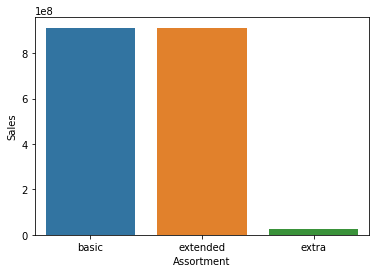

In [25]:
aux1= df4[['Assortment', 'Sales']].groupby( 'Assortment' ).sum().reset_index()
sns.barplot(x='Assortment',y='Sales', data=aux1);

é interessante investigar se o sortimento do tipo extra em algum ponto do passado vendeu mais e por algum motivo vendem menos e por este motivo a soma acumulada apareceu muito baixa

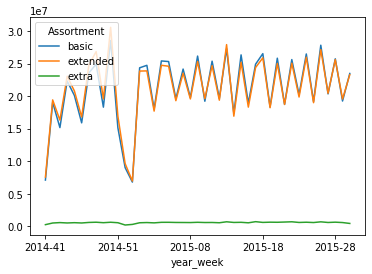

In [26]:
aux2 = df4[['year_week', 'Assortment', 'Sales']].groupby( ['year_week','Assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='Assortment', values='Sales' ).plot();

de acordo com o gráfico acima, podemos ver que basic e extended é muito semelhante e que o extra é muito pequeno, pois o volume dos outros tipos de assortment é tão grande que  extra fica tão pequeno

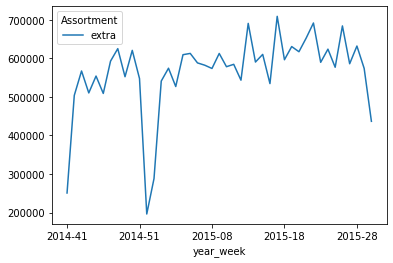

In [27]:
aux3 = aux2[aux2['Assortment'] == 'extra']
aux3.pivot( index='year_week', columns='Assortment', values='Sales' ).plot();

###H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** lojas com competidores mais próximos vendem **mais**

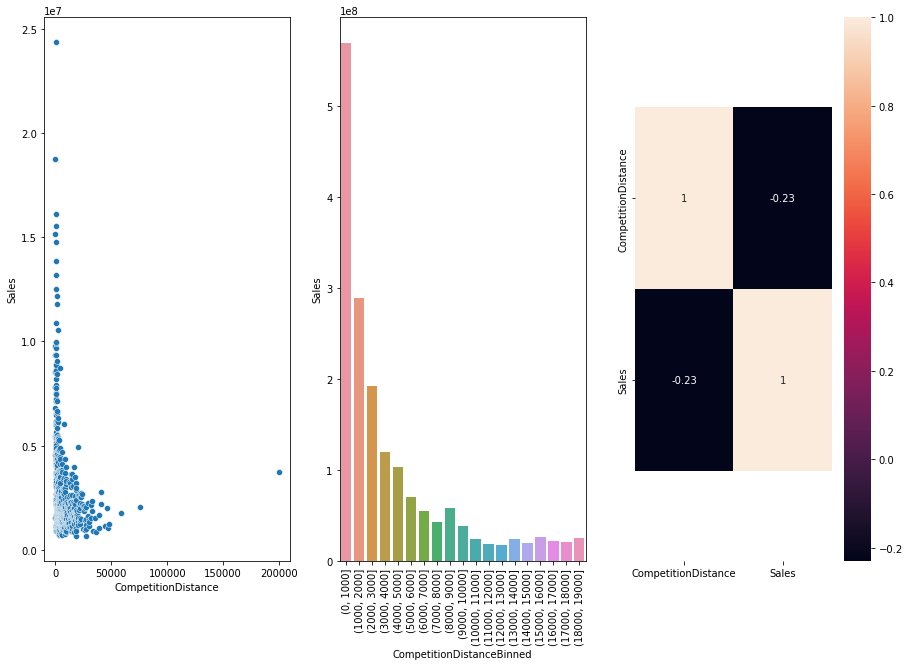

In [28]:
plt.figure(figsize=(15,10))
aux1 = df4[['CompetitionDistance', 'Sales']].groupby('CompetitionDistance').sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='CompetitionDistance', y='Sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['CompetitionDistanceBinned'] = pd.cut( aux1['CompetitionDistance'], bins=bins )
aux2 = aux1[['CompetitionDistanceBinned', 'Sales']].groupby( 'CompetitionDistanceBinned' ).sum().reset_index()
sns.barplot( x='CompetitionDistanceBinned', y='Sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [29]:
df4.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'CompetitionSince',
       'CompetitionTimeMonth', 'PromoSince', 'PromoTimeEeek'],
      dtype='object')

###H3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSO** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.



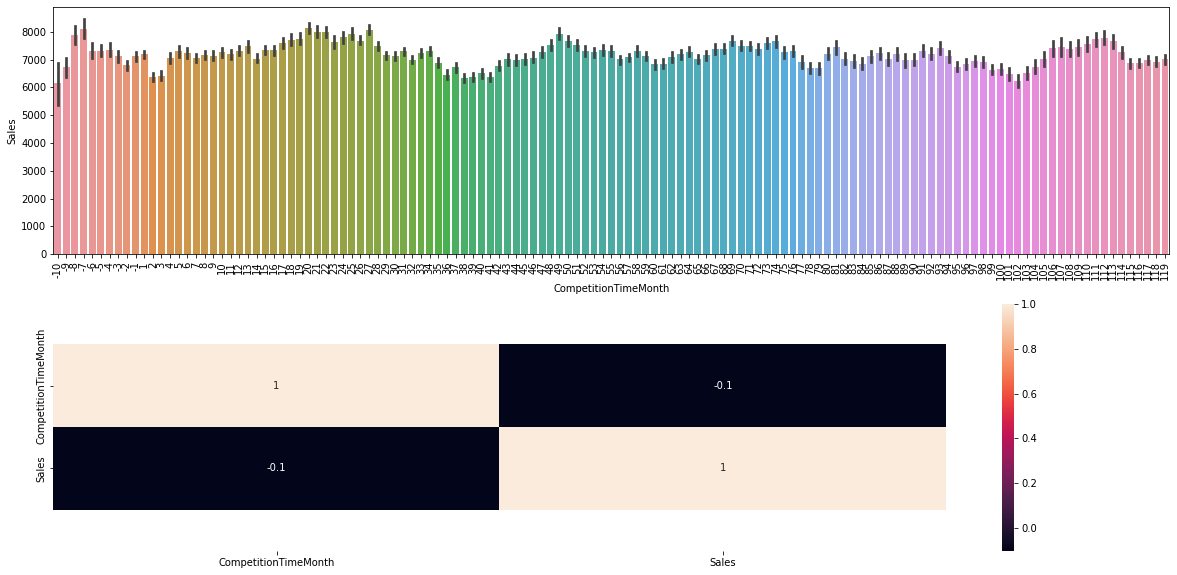

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(2,1, 1)
aux1= df4[['CompetitionTimeMonth', 'Sales']].groupby('CompetitionTimeMonth').sum().reset_index()
aux2 = df4[(df4['CompetitionTimeMonth']<120) & (df4['CompetitionTimeMonth']!=0)]#analisa os 120 primeiros meses da venda em que o competido abriu no mesmo mês da venda
sns.barplot( x='CompetitionTimeMonth', y='Sales', data=aux2 );
plt.xticks( rotation=90 );


plt.subplot( 2, 1, 2)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

O gráfico acima mostra que quanto mais recente é a competição maior é a venda

###H4. Lojas com promoções ativas por mais tempo deveriam vender mais.¶


###H5. Lojas com mais promoções consecutivas deveriam vender mais.


###H8. Lojas abertas durante o feriado de Natal deveriam vender mais.


##Análise Multi-variada
Irá saber a correlação entre as variáveis e que sao correlacionadas e podendo ser retiradas para diminuir a dimensionalidade e complexidade do modelo

Variáveis Numéricas 

<Figure size 1080x1080 with 0 Axes>

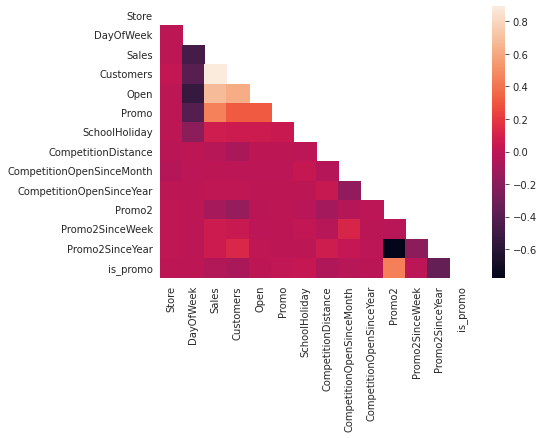

In [31]:
plt.figure(figsize=(15,15))

correlation = num_attributes.corr( method='pearson' )

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(correlation)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(correlation, mask=mask);
#sns.heatmap( correlation, annot=True, linewidths=.5,  vmax=.3, square=True);

Variáveis Categóricas

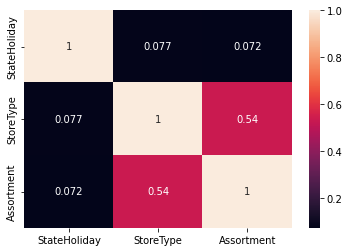

In [32]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['StateHoliday'], a['StateHoliday'] )
a2 = cramer_v( a['StateHoliday'], a['StoreType'] )
a3 = cramer_v( a['StateHoliday'], a['Assortment'] )

a4 = cramer_v( a['StoreType'], a['StateHoliday'] )
a5 = cramer_v( a['StoreType'], a['StoreType'] )
a6 = cramer_v( a['StoreType'], a['Assortment'] )

a7 = cramer_v( a['Assortment'], a['StateHoliday'] )
a8 = cramer_v( a['Assortment'], a['StoreType'] )
a9 = cramer_v( a['Assortment'], a['Assortment'] )

# Final dataset
d = pd.DataFrame( {'StateHoliday': [a1, a2, a3], 
               'StoreType': [a4, a5, a6],
               'Assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# Preparação dos Dados

In [33]:
df5 = df4.copy()

##Reescala

In [34]:
# competition distance
rs = RobustScaler()
mms = MinMaxScaler()
# fit transform acha os quartis da formula 1ro e 3ro da coluna e ja os aplica
df5['CompetitionDistance'] = rs.fit_transform( df5[['CompetitionDistance']].values )

# competition time month
df5['CompetitionTimeMonth'] = rs.fit_transform( df5[['CompetitionTimeMonth']].values )

# promo time week
df5['PromoTimeEeek'] = mms.fit_transform( df5[['PromoTimeEeek']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


##Mudança da Variável Categórica para Numérica

In [35]:
# variaveis categoricas

# state_holiday - one hot encoding
#prefix eh o nome que vai ficar na frente da coluna
df5=pd.get_dummies(df5,prefix=['StateHoliday'],columns=['StateHoliday'])


# store_type - Label Encoding
le=LabelEncoder()
df5['StoreType']=le.fit_transform(df5['StoreType'])

# assortment - ordinal encoding
assortment_dict={'basic':1, 'extra':2 , 'extended':3}
#map faz a substituicao da  string para o numero
df5['Assortment']=df5['Assortment'].map(assortment_dict)

##Transformação

In [36]:
df5['Sales'] = np.log1p( df5['Sales'] )#deixa a variável resposta mais proximo de uma normal


###Transformação de Natureza Cíclica


In [37]:
# day of week
df5['DayOfWeek'] = df5['DayOfWeek'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['DayOfWeek'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

#Seleção de Atributos
- Univariada
- Por Importancia
- Por Subset

Algoritmo Boruta

In [38]:
df6 = df5.copy()


Remove os atributos originais aqueles que já foram derivados

In [39]:
cols_drop = ['week_of_year', 'day', 'month', 'DayOfWeek', 'PromoSince', 'CompetitionSince', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

Separa os dados em treino e teste

Para isso os dados de treino serao extraídos a partir do primeiro dia de venda até 6 semanas(42 dias) antes do último dia de venda

In [40]:
df6[['Store','Date']].groupby('Store').max().reset_index()['Date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [41]:
# training dataset
X_train = df6[df6['Date'] < '2015-06-19']
y_train = X_train['Sales']

# test dataset
X_test = df6[df6['Date'] >= '2015-06-19']
y_test = X_test['Sales']

print( 'Training Min Date: {}'.format( X_train['Date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['Date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['Date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['Date'].max() ) )

Training Min Date: 2014-10-16 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [42]:

## training and test dataset for Boruta
#X_train_n = X_train.drop( ['Date', 'Sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Melhores Atributos Selecionados pelo Algoritmo Boruta

In [43]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['Date', 'Sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [44]:
#cols_selected_boruta

Seleção Manual de Atributos

In [45]:
cols_selected_boruta = ['Store',
                        'Promo',
                        'StoreType',
                        'Assortment',
                        'CompetitionDistance',
                        'CompetitionOpenSinceMonth',
                        'CompetitionOpenSinceYear',
                        'Promo2SinceWeek',
                        'Promo2SinceYear',
                        'CompetitionTimeMonth',
                        'PromoTimeEeek',
                        'day_of_week_cos',
                        'month_cos',
                        'day_sin',
                        'day_cos']
feat_to_add = ['Date', 'Sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

#MODELOS DE MACHINE LEARNING

In [46]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

##AVAREGE MODEL

In [47]:
aux1 = x_test.copy()
aux1['Sales'] = y_test.copy()

# prediction
aux2 = aux1[['Store', 'Sales']].groupby( 'Store' ).mean().reset_index().rename( columns={'Sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='Store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


##Regressão Linear

In [48]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1973.002895,0.32977,2701.437513


## Linear Regression Regularized Model - Lasso


In [49]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1921.07829,0.307568,2721.607295


##Random Forest Regressor

In [50]:
# # model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# # prediction
yhat_rf = rf.predict( x_test )

# # performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1038.993712,0.158467,1494.453731


##XGBoost Regressor

In [51]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1052.281413,0.164273,1461.013026


##Utilizando o Times Series Cross Validation para cada um dos Algoritmos

### Regressao Liner CV


In [52]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
x_training

,Store,Promo,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,CompetitionTimeMonth,PromoTimeEeek,day_of_week_cos,month_cos,day_sin,day_cos,Date,Sales
47945,1,1.0,2,1,-0.170968,9,2008,25,2015,0.647059,0.095376,0.925117,-1.0,-0.587785,-0.809017,2015-06-18,8.443762
47946,2,1.0,0,1,-0.283871,11,2007,13,2010,0.764706,0.884393,0.925117,-1.0,-0.587785,-0.809017,2015-06-18,8.547722
47947,3,1.0,0,1,1.903226,12,2006,14,2011,0.905882,0.731214,0.925117,-1.0,-0.587785,-0.809017,2015-06-18,8.927712
47948,4,1.0,2,3,-0.275806,9,2009,25,2015,0.505882,0.095376,0.925117,-1.0,-0.587785,-0.809017,2015-06-18,9.091669
47949,5,1.0,0,1,4.448387,4,2015,25,2015,-0.294118,0.095376,0.925117,-1.0,-0.587785,-0.809017,2015-06-18,8.502080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308213,929,0.0,0,3,0.401613,9,2013,42,2014,-0.164706,0.095376,0.925117,0.5,-0.207912,-0.978148,2014-10-16,8.532082
308214,930,0.0,0,1,-0.364516,10,2014,42,2014,-0.317647,0.095376,0.925117,0.5,-0.207912,-0.978148,2014-10-16,8.642768
308215,931,0.0,0,3,-0.137097,9,2011,1,2012,0.129412,0.517341,0.925117,0.5,-0.207912,-0.978148,2014-10-16,8.181441
308216,933,0.0,0,3,0.635484,2,2005,42,2014,1.070588,0.095376,0.925117,0.5,-0.207912,-0.978148,2014-10-16,8.768108


### Random Forest Regressor CV

In [53]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1313.76 +/- 516.64,0.18 +/- 0.06,1897.59 +/- 717.76


###XGBoost Regressor CV

In [54]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1329.59 +/- 394.74,0.18 +/- 0.03,1942.67 +/- 582.73


## Lasso CV

In [55]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2158.22 +/- 369.33,0.3 +/- 0.01,3089.8 +/- 551.03


##Comparação dos Algoritmos

Sem Cross Validation

In [56]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1052.281413,0.164273,1461.013026
0,Random Forest Regressor,1038.993712,0.158467,1494.453731
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1973.002895,0.329770,2701.437513
0,Linear Regression - Lasso,1921.078290,0.307568,2721.607295


Com Cross Validation

In [57]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2530.86 +/- 638.09,0.38 +/- 0.16,3445.99 +/- 552.47
0,Lasso,2158.22 +/- 369.33,0.3 +/- 0.01,3089.8 +/- 551.03
0,Random Forest Regressor,1313.76 +/- 516.64,0.18 +/- 0.06,1897.59 +/- 717.76
0,XGBoost Regressor,1329.59 +/- 394.74,0.18 +/- 0.03,1942.67 +/- 582.73


#Modelo

In [58]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,978.303787,0.151239,1357.500792


In [59]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.055658738446757644

# Tradução e Interpretação do Erro

In [63]:
df9= X_test[cols_selected_boruta_full]

# rescale
df9['Sales']= np.expm1(df9['Sales'])
df9['predictions']= np.expm1(yhat_xgb_tuned)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [65]:
# sum of prediction
df9['predictions']= np.expm1(yhat_xgb_tuned)
df91=df9[['Store','predictions']].groupby('Store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['Store','Sales','predictions']].groupby('Store').apply( lambda x: mean_absolute_error(x['Sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['Store','Sales','predictions']].groupby('Store').apply( lambda x: mean_absolute_percentage_error(x['Sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge (df9_aux1, df9_aux2, how='inner', on='Store')
df92= pd.merge (df91,df9_aux3, how='inner', on='Store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']


#order columns
df92=df92[['Store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
df92.sort_values('MAPE',ascending=False).head()


,Store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,114386.562500,110719.614926,118053.510074,3666.947574,0.693040
908,909,249721.312500,242282.705354,257159.919646,7438.607146,0.526656
875,876,209306.078125,204364.465693,214247.690557,4941.612432,0.471170
482,483,194560.703125,193247.876181,195873.530069,1312.826944,0.389332
606,607,153380.968750,152487.039000,154274.898500,893.929750,0.362625


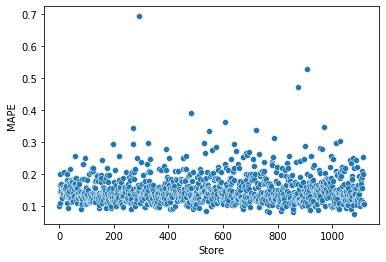

In [69]:
sns.scatterplot(x='Store', y='MAPE', data=df92);


## Performace Total

In [70]:
df9['error']=df9['Sales'] - df9['predictions']
df9['error_rate']=df9['predictions'] / df9['Sales']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


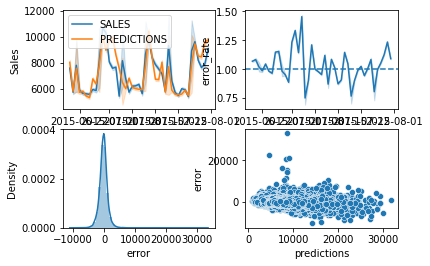

In [71]:
plt.subplot(2,2,1)
sns.lineplot (x='Date', y='Sales', data=df9, label='SALES') 
sns.lineplot (x='Date', y='predictions', data=df9, label='PREDICTIONS') 

plt.subplot(2,2,2)
sns.lineplot (x='Date', y='error_rate', data=df9,)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot (df9['error'])

plt.subplot(2,2,4)
sns.scatterplot (df9['predictions'], df9['error'])

# Deploy do Modelo

In [74]:
pickle.dump( model_xgb_tuned, open( '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/model_rossmann.pkl', 'wb') )


## Classe Rossmann

In [76]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## API do Handler

In [82]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
#from rossmann.Rossmann import Rossmann


# loading model
model = pickle.load( open( '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( host ='127.0.0.1', port=5000, debug=True)